L'objectif des cellules de codes ci dessous est de construire à l'aide d'un **CNN** (Convolution Neural Network ou réseau neuronal convolutif) une **reconnaissance des émotions**. Pour se faire il nous faut une base d'apprentissage mais également d'entrainement, nous allons utiliser pour ça le dataset FER-2013 disponibe sur Kaggle (https://www.kaggle.com/msambare/fer2013).

Ce dataset est constitué d'images de visages en niveaux de gris de 48x48 pixels. Ces visages sont plus ou moins centrés et occupent chacunes à peu près le même espace.

Chaques visages appartient à l'une des 7 émotions suivantes : 

  * La colère

  * Le dégoût

  * La peur

  * La joix

  * La tristesse

  * La surprise

  * Neutre

L'ensemble d'entraînement comprend 28 709 images tandis que l'ensemble de test lui en comprend 7 178.

***/!\ Petite précision, le GPU doit être selectionné comme accélérateur matériel pour la bonne exécution.*** 

Commençons par réaliser les imports nécessaire.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
import numpy as np

Le dataset contenant les images d'apprentissages et d'entrainements doit être importé dans l'environnement google (si exécuté depuis colab), voici à nouveau le [lien](https://www.kaggle.com/msambare/fer2013) pour le télécharger sous le nom *archive.zip*.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 63252113 bytes


In [ ]:
from zipfile import ZipFile
file_name = "archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

ImageDataGenerator réalise ce qui s'appelle une augmentation de données, c'est à dire qu'on va appliquer à un lot d’images des **transformations aléatoires ou prédéfinie** et ainsi remplacer le lot d’origine par ces nouvelles données qui vont servir à l’apprentissage. Un intérêt supplémentaire est que l’augmentation est faite durant l’apprentissage (on-the-fly) et permet encore d'économiser de la mémoire tampon.

<img src="https://pyimagesearch.com/wp-content/uploads/2019/07/keras_data_augmentation_header.png" alt="ImageDataGenerator" />

On définit les paramètres de ```flow_from_directory()``` comme elles devraient l'être (taille en pixels, niveaux de gris, catégories pour les émotions et non binaire), et on va définir le nombre d'images par lot à extraire du générateur à 64 pour que ce ne soit pas énormément long.



In [ ]:
traindata_generator = ImageDataGenerator(rescale=1./255)
validationdata_generator = ImageDataGenerator(rescale=1./255)

training_generator = traindata_generator.flow_from_directory(
        directory='train',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = validationdata_generator.flow_from_directory(
        directory='test',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Il est maintenant tant de construire le CNN, réseau de neuronnes convolutif qui est particulièrement bien adapté aux classifications d'images.

Les applications suivantes sont nécessaire pour construire le modèle :

Les **fonctions d'activation** sont utilisées pour obtenir les valeurs résultantes dans la plage de 0 à 1 ou de -1 à 1 selon la fonction. Il existe deux types de fonctions d'activation, **linéaires** et **non linéaires**, ici on utilise ***Rectified Linear Unit*** (ReLU) qui est donc linéaire et ***Softmax*** qui est une normalisation non linéaire et réagit mieux à de faible stimulation dû à l'exponentiel.

Les **couches de *pooling*** sont utilisées pour réduire le nombre de paramètres lorsque les images sont trop grandes. Le sous-échantillonnage **réduit la dimensionnalité de chaque couche mais conserve les caractéristiques importantes**.

<img src="https://images.deepai.org/glossary-terms/4b19331a4b0a455cbefd00488dfc4ef4/max_pooling_jpg.jpg" alt="Pooling" width="400" height="200" />

Le ***Dropout*** pendant la phase d'apprentissage consiste à ne pas prendre en compte pendant un passage particulier en avant ou en arrière des neurones d'un certain ensemble de neurones choisi aléatoirement. Le *dropout* permet plus particulièrement d'**éviter le surapprentissage.**

<img src="https://cdn-images-1.medium.com/max/1000/1*uxpH46OpTIj63j1MKQ-T2Q.png" alt="Dropout" width="400" height="200" />

Enfin ***Dense*** est la seule couche réelle du réseau de neuronnes, elle transmet toutes les outputs de la couche précédente à ses neurones, chaque neurone fournissant alors une output à la couche suivante. Dense possède le nombre de neuronnes qu'on lui attribut.

<img src="https://www.researchgate.net/publication/339278442/figure/fig2/AS:858656040026112@1581730961911/Representation-of-the-architecture-of-a-convolutional-neural-network-CNN.ppm" alt="Dense" />

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

***categorical_crossentropy*** est une fonction de perte qui est utilisée dans les tâches de classification avec plusieurs catégories. Elle est utilisée dans les tâches où un exemple ne peut **appartenir qu'à une seule des nombreuses catégories possibles**, et où le modèle doit décider laquelle.

On choisit par ailleurs l'**optimiseur Adam** qui est une méthode de **descente de gradient** stochastique reposant sur l'estimation des moments du premier et du second ordre.

Enfin on définit le nombre d'***epochs*** à 50 (1 epoch = 1 cycle entier d'entrainement sur le dataset).

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model.fit_generator(training_generator, steps_per_epoch=28709 // 64, epochs=50, validation_data=validation_generator, validation_steps=7178 // 64)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
448/448 [==============================] - 27s 26ms/step - loss: 1.8003 - accuracy: 0.2630 - val_loss: 1.7031 - val_accuracy: 0.3400
Epoch 2/50
448/448 [==============================] - 11s 24ms/step - loss: 1.6295 - accuracy: 0.3647 - val_loss: 1.5371 - val_accuracy: 0.4124
Epoch 3/50
448/448 [==============================] - 11s 24ms/step - loss: 1.5226 - accuracy: 0.4162 - val_loss: 1.4494 - val_accuracy: 0.4508
Epoch 4/50
448/448 [==============================] - 12s 26ms/step - loss: 1.4479 - accuracy: 0.4459 - val_loss: 1.3849 - val_accuracy: 0.4734
Epoch 5/50
448/448 [==============================] - 11s 24ms/step - loss: 1.3890 - accuracy: 0.4698 - val_loss: 1.3382 - val_accuracy: 0.4941
Epoch 6/50
448/448 [==============================] - 11s 24ms/step - loss: 1.3395 - accuracy: 0.4913 - val_loss: 1.3034 - val_accuracy: 0.5029
Epoch 7/50
448/448 [==============================] - 11s 24ms/step - loss: 1.3006 - accuracy: 0.5062 - val_loss: 1.2769 - val_accuracy:

Nous atteignons une précision d'environ **62 %** sur l'échantillon de validation ce qui n'est pas fameux d'autant plus que l'on voit que sur le modèle d'entrainement on atteint les 86 % ce qui peut laisser paraitre un surapprentissage au vu de la différence que l'on a entre les deux.

Pour remédier à ça on peut **agrandir l'échantillon d'entrainement** et éventuellement **augmenter le nombre d'étapes**.

___

Nous allons maintenant écrire les fonctions nécssaire à la visualisation des résultats.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import matplotlib.pyplot as plt
from base64 import b64decode

In [ ]:
def take_photo(filename='emotion.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def emotion_analysis(emotions):
    emotions_list = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y = np.arange(len(emotions_list))
    
    plt.bar(y, emotions, align='center', alpha=0.5)
    plt.xticks(y, emotions_list)
    plt.ylabel('estimate percentage')
    plt.title('emotions')
    
    plt.show()

Prenez une photo et l'algorithme essaiera de deviner les émotions retransmise.

In [55]:
take_photo()

<IPython.core.display.Javascript object>

'emotion.jpg'

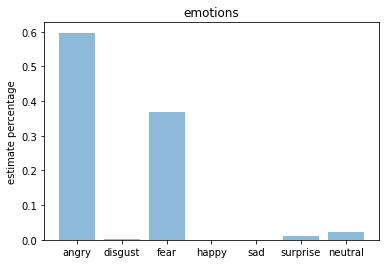

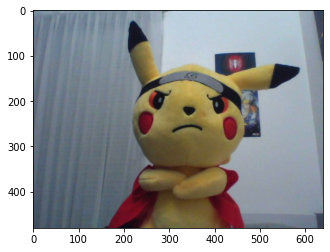

In [56]:
file = '/content/emotion.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()